# Camera Calibration

* https://docs.opencv.org/master/d6/d55/tutorial_table_of_content_calib3d.html
* https://www.mathworks.com/help/vision/ug/camera-calibration.html
* http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

## Create Calibration Pattern
* https://docs.opencv.org/master/d6/d55/tutorial_table_of_content_calib3d.html

Now, if you want to create your own pattern, you will need python to use https://github.com/opencv/opencv/blob/master/doc/pattern_tools/gen_pattern.py

```    
python gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20


python gen_pattern.py -o circleboard.svg --rows 7 --columns 5 --type circles --square_size 15
 
python gen_pattern.py -o acircleboard.svg --rows 7 --columns 5 --type acircles --square_size 10 --radius_rate 2
```

In [2]:
# run the script to get an svg image file
!python3 opencv-doc/pattern_tools/gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20

In [3]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
drawing = svg2rlg('chessboard.svg')
renderPDF.drawToFile (drawing, 'chesspoard.pdf')

---
## Camera Calibration
---
- https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

<img src="camcal/1.png">
<img src="camcal/2.png">

Thus, if an image from the camera is scaled by a factor, all of these parameters should be scaled (multiplied/divided, respectively) by the same factor. The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene, or vice versa, rigid motion of an object in front of a still camera. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when z \ne 0 ):

<img src="camcal/3.png">

**Pin-hole Camera Model**

<img src="camcal/pinhole_camera_model.png">

Real lenses usually have some distortion, mostly radial distortion and slight tangential distortion. So, the above model is extended as:

<img src="camcal/4.png">

The next figure shows two common types of radial distortion: barrel distortion (typically $k_1 > 0$ and pincushion distortion (typically $k_1 < 0$).

<img src="camcal/5.png">

default distort_parameters = $[k_1, k_2, p_1, p_2, k_3]$

### First, set the size of the pattern and its corresponding World coordinates

In [4]:
import glob
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) ...
patternSize = (9,6)
objp = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
objp[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
print (objp[0:10])

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]]


### Image detection of the chessboard corners.

In [5]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
imagefiles = sorted(glob.glob('opencv_samples_data/left*.jpg'))
for i, fname in enumerate(imagefiles):
    print ('processing: ', fname)
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, patternSize=patternSize)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, patternSize=patternSize, corners=corners2, patternWasFound=ret)
        cv.imshow('img', img)
        outfname = f'results/calib-pattern-res-{i:02d}.png'
        cv.imwrite(outfname, img)
        print ('   --> ', outfname)
        cv.waitKey(500)
    else:
        print ('   --> skip.')
cv.destroyAllWindows()

processing:  opencv_samples_data/left.jpg
   --> skip.
processing:  opencv_samples_data/left01.jpg
   -->  results/calib-pattern-res-01.png
processing:  opencv_samples_data/left02.jpg
   -->  results/calib-pattern-res-02.png
processing:  opencv_samples_data/left03.jpg
   -->  results/calib-pattern-res-03.png
processing:  opencv_samples_data/left04.jpg
   -->  results/calib-pattern-res-04.png
processing:  opencv_samples_data/left05.jpg
   -->  results/calib-pattern-res-05.png
processing:  opencv_samples_data/left06.jpg
   -->  results/calib-pattern-res-06.png
processing:  opencv_samples_data/left07.jpg
   -->  results/calib-pattern-res-07.png
processing:  opencv_samples_data/left08.jpg
   -->  results/calib-pattern-res-08.png
processing:  opencv_samples_data/left09.jpg
   -->  results/calib-pattern-res-09.png
processing:  opencv_samples_data/left11.jpg
   -->  results/calib-pattern-res-10.png
processing:  opencv_samples_data/left12.jpg
   -->  results/calib-pattern-res-11.png
processing

In [6]:
ip = imgpoints[-1].copy()
print(ip.shape)
ip = ip.reshape(ip.shape[0], ip.shape[2])
print(ip.shape, ip[0])

(54, 1, 2)
(54, 2) [416.2941    57.344814]


### Let's see the image locations of the world orgin, x-axis, and y-axis points.

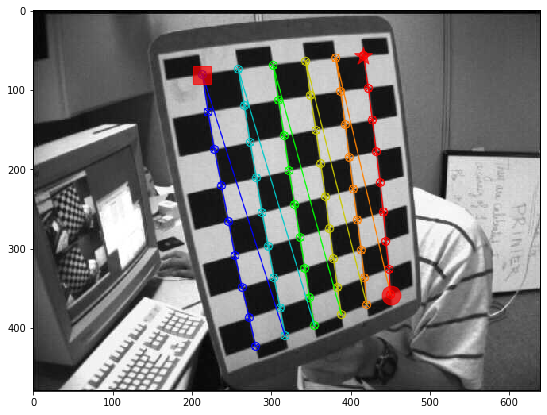

In [7]:
plt.figure(figsize=(10,7))
plt.imshow (img[:,:,::-1]) # BGR -> RGB for plt.imshow()
i = 0 # The world origin
plt.scatter(ip[i,0], ip[i,1], marker='*', color='r', s=350, alpha=0.7)
# The end tip of x-axis
i = patternSize[0] - 1  
plt.scatter(ip[i,0], ip[i,1], marker='o', color='r', s=350, alpha=0.7)
# the end tip of y-axis
i = patternSize[0] * (patternSize[1]-1) 
plt.scatter(ip[i,0], ip[i,1], marker='s', color='r', s=350, alpha=0.7)

Now we can see that the z-axis of the world goes down towards the person from the origin.

### Calibration
Now that we have our object points and image points, we are ready to go for calibration. We can use the function, `cv.calibrateCamera()` which returns the camera matrix, distortion coefficients, rotation and translation vectors etc. 

In [8]:
ret, Kmat, distCoeff, rvecs, tvecs = cv.calibrateCamera(objpoints, 
                                                  imgpoints, 
                                                  imageSize=gray.shape[::-1], 
                                                  cameraMatrix=None, distCoeffs=None)

In [9]:
Kmat

array([[536.07343678,   0.        , 342.37038243],
       [  0.        , 536.01635208, 235.53685416],
       [  0.        ,   0.        ,   1.        ]])

In [10]:
distCoeff

array([[-0.26509011, -0.04674355,  0.00183301, -0.00031471,  0.25231509]])

In [11]:
rvecs[:2]

[array([[0.16853568],
        [0.27575315],
        [0.01346807]]), array([[ 0.41306754],
        [ 0.64934522],
        [-1.33719481]])]

In [12]:
tvecs[:2]

[array([[-3.01118527],
        [-4.3575667 ],
        [15.99287311]]), array([[-2.34551346],
        [ 3.31931524],
        [14.15396047]])]

### Re-projection Test

In [13]:
proj, _ = cv.projectPoints(objpoints[-1], rvecs[-1], tvecs[-1], Kmat, distCoeff)
proj.shape

(54, 1, 2)

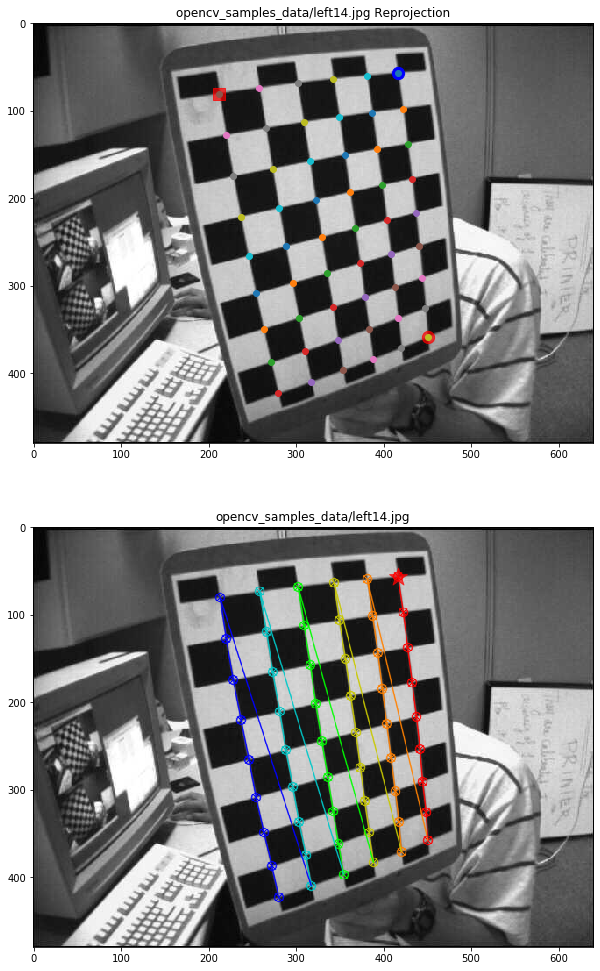

In [14]:

fig, ax = plt.subplots(2,1, figsize=(15,17))
ax[1].set_title(imagefiles[-1])
ax[1].imshow(img[:,:,::-1])
i = 0 # The world origin
ax[1].scatter(ip[i,0], ip[i,1], marker='*', color='r', s=350, alpha=0.7)

simg = cv.imread(imagefiles[-1])
ax[0].imshow(simg[:,:,::-1])
ax[0].set_title(imagefiles[-1] + ' Reprojection')
i = 0 # The origin point
ax[0].scatter(proj[0,0,0], proj[0,0,1], marker='o', color='b', s=150) 
i = patternSize[0] - 1  # The end of the x-axis
ax[0].scatter(proj[i,0,0], proj[i,0,1], marker='o', color='r', s=150, alpha=0.7)
# the end tip of y-axis
i = patternSize[0] * (patternSize[1]-1) 
ax[0].scatter(proj[i,0,0], proj[i,0,1], marker='s', color='r', s=150, alpha=0.7)
#

pp = proj.reshape(-1, 2)
for xy in pp:
    ax[0].scatter(xy[0], xy[1])
    

### Reprojection Step-by-step

In [15]:
X3dW = objpoints[0].T
X3dW.shape

(3, 54)

In [16]:
X3dW[:,:7]

array([[0., 1., 2., 3., 4., 5., 6.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

**Rotation**

Conversion of rvec to R mat:

<img src="camcal/rodrigues_eq.png">

In [17]:
Rmat, _ = cv.Rodrigues(rvecs[-1])
Rmat

array([[ 0.14628383, -0.89499702, -0.42140406],
       [ 0.96235226,  0.22739732, -0.1488912 ],
       [ 0.22908333, -0.38375877,  0.89456695]])

In [18]:
Xc = Rmat @ X3dW
Xc[:,:4]

array([[0.        , 0.14628383, 0.29256766, 0.43885148],
       [0.        , 0.96235226, 1.92470452, 2.88705677],
       [0.        , 0.22908333, 0.45816666, 0.68724999]])

**Translation**

In [19]:
print ('translation vector: ', tvecs[-1].T)

translation vector:  [[ 1.79855747 -4.32644219 12.50141687]]


In [20]:
Xc = Xc + tvecs[-1]
Xc[:,:4]

array([[ 1.79855747,  1.9448413 ,  2.09112513,  2.23740896],
       [-4.32644219, -3.36408993, -2.40173767, -1.43938541],
       [12.50141687, 12.7305002 , 12.95958353, 13.18866687]])

**Projection**

In [21]:
zc = Xc[2,:]
Xc = Xc / zc # [x/z, y/z, 1]
Xc[:, :4]

array([[ 0.14386829,  0.15277022,  0.16135743,  0.16964633],
       [-0.34607615, -0.26425434, -0.18532522, -0.10913805],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

**Lens distortion**

<img src="camcal/4.png">

In [22]:
distCoeff

array([[-0.26509011, -0.04674355,  0.00183301, -0.00031471,  0.25231509]])

In [23]:
def lens_distort(xyarr, dc):
    distorted = xyarr.copy()
    k1,k2,p1,p2,k3 = dc
    for dxy, xy in zip(distorted.T, xyarr.T):
        #print (xy, "--")
        r2 = xy[0]**2 + xy[1]**2
        radial = (1 + k1*r2 + k2*np.power(r2,2) + k3*np.power(r2,3)) #
        dxy[0] = xy[0] * radial + 2*p1*xy[0]*xy[1] + p2*(r2 + 2*xy[0]**2)
        dxy[1] = xy[1] * radial + p1*(r2 + 2*xy[1]**2) + 2*p2*xy[0]*xy[1]
        
    #
    return distorted
#

Xdistorted = lens_distort(Xc, distCoeff[0])
Xdistorted[:,:4]

array([[ 0.13823931,  0.14877425,  0.1586111 ,  0.16770735],
       [-0.33238447, -0.25722224, -0.18208209, -0.10782431],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

**Image Scaling and Translation**

In [24]:
Ximg = Kmat @ Xdistorted
Ximg[:, :4]

array([[416.4768067 , 422.12430353, 427.39757854, 432.27383865],
       [ 57.37334281,  97.66152558, 137.93787441, 177.74126336],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

#### Comparison

In [25]:
proj, _ = cv.projectPoints(objpoints[-1], rvecs[-1], tvecs[-1], Kmat, distCoeff)
proj = proj.reshape(-1,2).T
proj[:,:4]

array([[416.4768  , 422.1243  , 427.39758 , 432.27383 ],
       [ 57.373344,  97.66152 , 137.93788 , 177.74126 ]], dtype=float32)

In [26]:
myProj = Ximg[:2, :]
myProj[:,:4]

array([[416.4768067 , 422.12430353, 427.39757854, 432.27383865],
       [ 57.37334281,  97.66152558, 137.93787441, 177.74126336]])

In [27]:
dist = myProj - proj

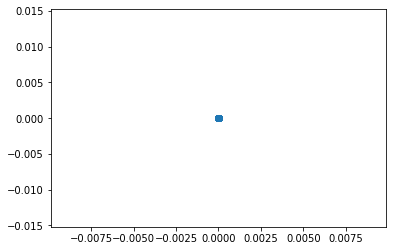

In [28]:
plt.scatter (dist[0,:], dist[1,:])

Text(0.5, 1.0, 'distance between my projection and opencv-projection (in pixel unit)')

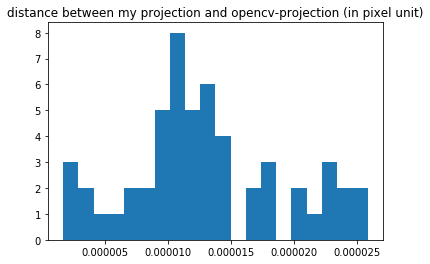

In [29]:
d_l2 = np.abs(dist[0]) + np.abs(dist[1])
plt.hist(d_l2, bins=20)
plt.title('distance between my projection and opencv-projection (in pixel unit)')

So our step-by-step projection gives the same output as cv.reprojection within the numerical computation error.

### Reprojection Error

In [30]:
total_rms = 0
for i in xrange(len(objpoints)):
    proj, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], Kmat, distCoeff)
    error = imgpoints[i] - proj
    error = error.reshape(-1,2).T
    
    e2 = error[0]**2 + error[1]**2
    e2 = e2.sum()
    total_rms += e2
#
total_rms = np.sqrt(total_rms / (len(objpoints) * objpoints[0].shape[0]))

print( "total rms: {:.2f} pixels".format(total_rms))

total rms: 0.41 pixels


### Undistorted Image Computation

In [31]:
filename = imagefiles[-1]
src = cv.imread(filename) # choose a file
h, w = src.shape[:2]
newKmat, roi = cv.getOptimalNewCameraMatrix (Kmat, distCoeff, imageSize=(w,h), alpha=1, newImgSize=(w,h))

In [32]:
roi

(4, 17, 625, 448)

In [33]:
newKmat

array([[469.45767212,   0.        , 341.99905073],
       [  0.        , 470.03918457, 236.70663497],
       [  0.        ,   0.        ,   1.        ]])

In [34]:
Kmat

array([[536.07343678,   0.        , 342.37038243],
       [  0.        , 536.01635208, 235.53685416],
       [  0.        ,   0.        ,   1.        ]])

**cv.undistort()**

In [35]:
undistorted = cv.undistort (src, Kmat, distCoeff, None, newKmat)
undistorted.shape

(480, 640, 3)

Text(0.5, 1.0, 'Undistorted Image')

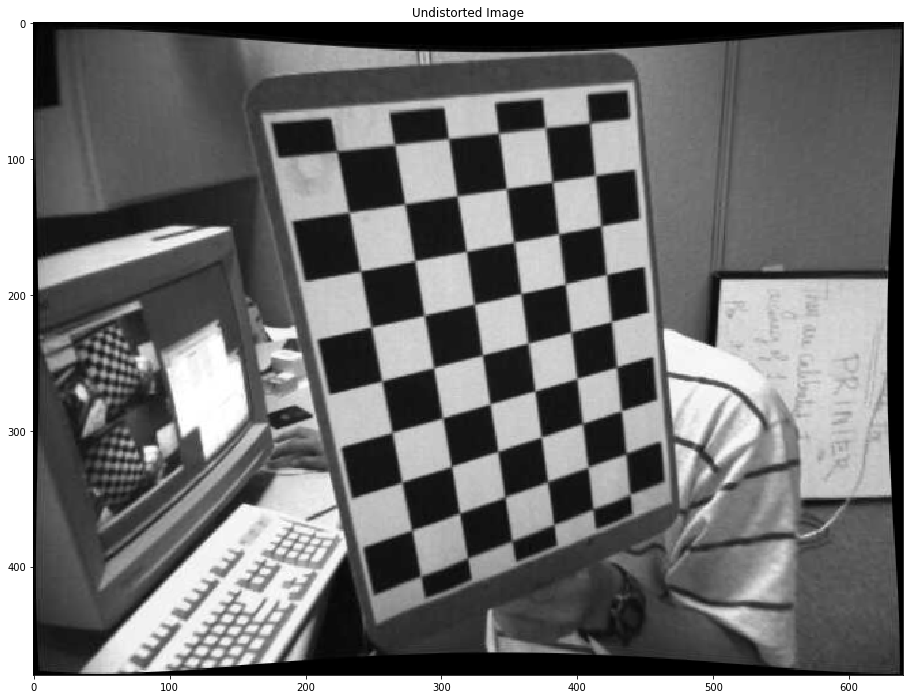

In [36]:
plt.figure(figsize=(16, 12))
plt.imshow(undistorted)
plt.title('Undistorted Image')

## Conclusion

Well, that's it.

When your camera seems to have lens distortion, then try to use this approach.

**Q. Take several photos of the calibration pattern and calibrate your phone's camera.**

# Camera Pose Estimation
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html


## Conclusion
- Now it's time to have a look at methods of keypoint detection and matching